<a href="https://colab.research.google.com/github/SanghunOh/study_machinglearning/blob/main/codes/yanginsuk/ch7_%EA%B5%B0%EC%A7%91%ED%99%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

군집화[실습]

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

mpl.rc('font', family='NanumGothic') # 폰트 설정
mpl.rc('axes', unicode_minus=False) # 유니코드에서 음수 부호 설정

# 차트 스타일 설정
sns.set(font="NanumGothic", rc={"axes.unicode_minus":False}, style='darkgrid')
plt.rc("figure", figsize=(10,8))

warnings.filterwarnings("ignore")

1. Online Retail 데이터Permalink
 실습 예제로는 UCI Machine Learning Repository에서 다운 받을 수 있는 Online Retail 데이터를 사용한다.

 해당 데이터로 고객 세그먼테이션(다양한 기준으로 고객을 분류하는 기법)을 진행할 것이다.
 고객 세그먼테이션에선 어떤 요소를 기반으로 군집화할 것인지가 중요하다.
 여기서는 RFM기법을 사용해본다.

*   RECENCY (R): 가장 최근 상품 구입 일에서 오늘까지의 기간
*   FREQUENCY (F): 상품 구매 횟수
*   MONETARY VALUE (M): 총 구매 금액

1.1 데이터 핸들링Permalink
---

데이터 구조

*   InvoiceNo: 주문번호 (C로 시작하는 것은 취소 주문)
*   StockCode: 제품 코드
*   Description: 제품 설명
*   Quantity: 주문 제품 건수
*   InvoiceDate: 주문 일자
*   UnitPrice: 제품 단가
*   CustomerID: 고객 번호
*   Country: 주문 고객의 국적

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
retail_df = pd.read_excel("/content/drive/MyDrive/yanginsuk/Online_Retail.xlsx")
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [14]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


*   데이터는 541,909 x 8로 이루어져 있다.
*   Description, CustomerID는 결측이 존재하며, CustomerID는 약 13만 건 정도의 결측값이 존재한다.
*   여기선 고객 세그먼테이션을 수행하므로 CustomerID가 결측이면 모두 제거한다.

In [15]:
retail_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


*   Quantity는 주문 제품 건수로 음수가 존재해선 안되는데 min 값에 음수가 있다.
*   UnitPrice 역시 제품 단가로 음수가 존재해선 안되는데 min 값에 음수가 있다.
*   사실 여기서 음수는 취소된 건수, 단가를 의미한다고 한다(InvoiceNo가 C로 시작).
*   여기선 음수값들은 모두 제거하고 분석을 진행하도록 한다.

In [16]:
# 데이터 핸들링
con_1 = retail_df.Quantity > 0
con_2 = retail_df.UnitPrice > 0
con_3 = retail_df.CustomerID.notnull()

retail_df = retail_df[con_1 & con_2 & con_3]
print(retail_df.shape)
print(retail_df.isnull().sum())

(397884, 8)
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


*   앞서 설정한 조건으로 데이터를 삭제하여 397,884건만 남겨두었다.
*   더불어서 Description의 결측값도 모두 삭제되었다.

In [17]:
# 주문 국적 확인
retail_df.Country.value_counts()[:10]

United Kingdom    354321
Germany             9040
France              8341
EIRE                7236
Spain               2484
Netherlands         2359
Belgium             2031
Switzerland         1841
Portugal            1462
Australia           1182
Name: Country, dtype: int64

*   주문 국적은 전체 데이터의 대부분이 영국으로 나타나 영국만 남기기로 한다.

In [18]:
# 주문 국적 영국만 남기기
retail_df = retail_df[retail_df["Country"] == "United Kingdom"]
print(retail_df.shape)

(354321, 8)


In [19]:
# 데이터 추가 가공
retail_df["sale_amount"] = retail_df["Quantity"] * retail_df["UnitPrice"]
retail_df["CustomerID"] = retail_df["CustomerID"].astype(int)

*   Quantity(주문 제품 건수)와 UnitPrice(제품 단가)를 곱하여 sale_amount(주문 금액)을 생성하였다.
*   CustomerID는 기존 float형을 int형으로 바꿔주었다.

In [20]:
# 주문번호 + 상품코드
print(retail_df.groupby(["InvoiceNo", "StockCode"]).size().mean())

1.028702077315023


*   주문번호 + 상품코드 갯수의 평균은 거의 1로서 주문번호 + 상품코드는 식별자 레벨로 사용 가능하다.
*   다만 여기선 RFM 기반의 고객 세그먼테이션으로 고객 레벨로 분석을 해야한다.
*   따라서, 주문번호 + 상품코드 기준 데이터를 고객 기준의 RFM 데이터로 변경한다.

In [21]:
# Recency (R): 가장 최근 상품 구입 일에서 오늘까지의 기간
# Frequency (F): 상품 구매 횟수
# Monetary Value (M): 총 구매 금액

aggregations = {
    "InvoiceDate": "max", # 최근 구입 일자
    "InvoiceNo": "count", # 상품 구매 횟수
    "sale_amount": "sum"  # 총 구매 금액
}

# 고객 기준의 RFM 데이터
cust_df = retail_df.groupby("CustomerID").agg(aggregations)
cust_df = cust_df.rename(columns = {"InvoiceDate":"Recency",
                                    "InvoiceNo":"Frequency",
                                    "sale_amount":"Monetary"}
                        )
cust_df = cust_df.reset_index()

cust_df.head(3)

,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12747,2011-12-07 14:34:00,103,4196.01
2,12748,2011-12-09 12:20:00,4595,33719.73


*   RFM 데이터를 만들기 위해 기존 컬럼을 agg()를 활용해서 각각 다른 연산을 수행하였다.
*   Recency의 경우 현재 최근 구입 날짜로 변경해서 한번 더 작업이 필요하다.

In [22]:
import datetime as dt

# Recency
cust_df['Recency'] = dt.datetime(2011,12,10) - cust_df['Recency']
cust_df['Recency'] = cust_df['Recency'].apply(lambda x: x.days+1)

cust_df.head(3)

,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12747,3,103,4196.01
2,12748,1,4595,33719.73


*   현재 사용하는 데이터는 2010년 12월 1일 ~ 2011년 12월 9일까지의 데이터이다.
*   따라서 Recency를 구할 때 오늘까지의 기간은 2011년 12월 10일까지의 기간으로 계산하였다.

In [23]:
print(cust_df.shape)

(3920, 4)



*   지금까지의 가공으로 고객 기준의 RFM 데이터는 3,920 x 4로 이루어져있다.

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


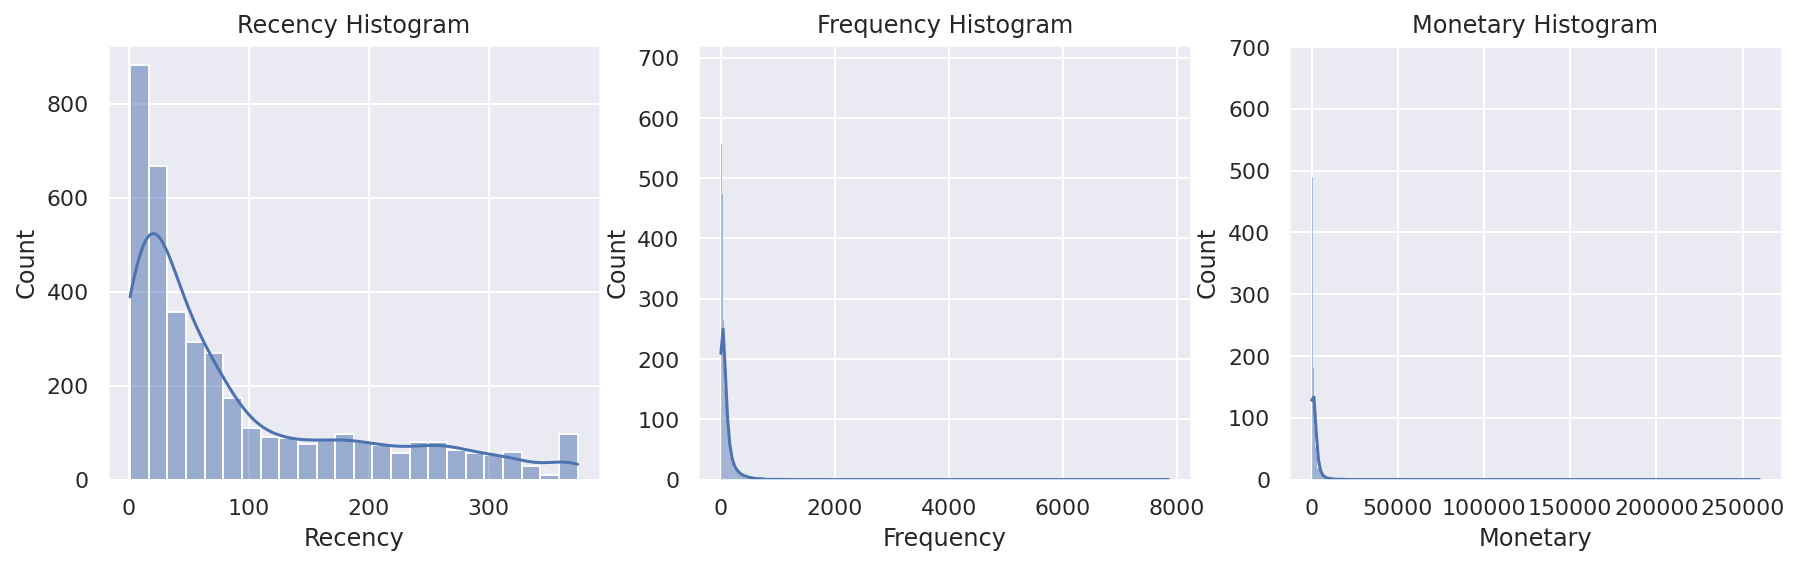

In [24]:
fig, axs = plt.subplots(1,3, figsize=(15,4))

sns.histplot(cust_df['Recency'], kde=True, ax=axs[0])
axs[0].set_title('Recency Histogram')

sns.histplot(cust_df['Frequency'], kde=True, ax=axs[1])
axs[1].set_title('Frequency Histogram')

sns.histplot(cust_df['Monetary'], kde=True, ax=axs[2])
axs[2].set_title('Monetary Histogram')

plt.show()

*   cust_df의 R,F,M의 분포를 확인하였다.
*   모두 치우친 분포로 나타났으며 특히, F와 M은 매우 심하게 치우쳐있다.
*   이는 이 데이터가 개인 고객과 소매업체의 대규모 주문이 포함되어 있어 나타난 현상이다.

In [25]:
cust_df.describe().iloc[:,1:]

,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000
mean,92.742092,90.388010,1864.385601
std,99.533485,217.808385,7482.817477
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,300.280000
50%,51.000000,41.000000,652.280000
75%,143.000000,99.250000,1576.585000
max,374.000000,7847.000000,259657.300000


*   각 컬럼들의 평균은 중앙값보다 훨씬 크게 나타나며, 75% 분위수에 비해 최대값이 훨씬 크다.
*   왜곡이 심한 데이터를 이용해서 군집분석을 진행해보자.

1.2 군집분석

---
실루엣 계수 및 군집 시각화 함수는 교재 소스코드를 사용하였다.

**실루엣 계수 시각화 함수**


In [26]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

**군집갯수별 시각화 함수**

In [27]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 클러스터링 결과를 시각화 
def visualize_kmeans_plot_multi(cluster_lists, X_features):
    
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])
    
     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels
        
        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*']
       
        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)           
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))    
        axs[ind].legend(loc='upper right')
    
    plt.show()

**1.2.1 StandardScaler**

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# StandardScaler
X_features = cust_df[['Recency','Frequency','Monetary']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

# KMeans
kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df["cluster_label"] = labels

# 실루엣 스코어
silhouette_kmeans = silhouette_score(X_features_scaled, labels)
print(f"실루엣 스코어: {silhouette_kmeans:.3f}")

실루엣 스코어: 0.592


*   KMeans 군집분석을 진행하였고 피처는 표준화하였다.
*   실루엣 스코어가 0.592로 제법 좋은 수치로 나타났다.
*   각 군집별 실루엣 스코어를 확인해보자.

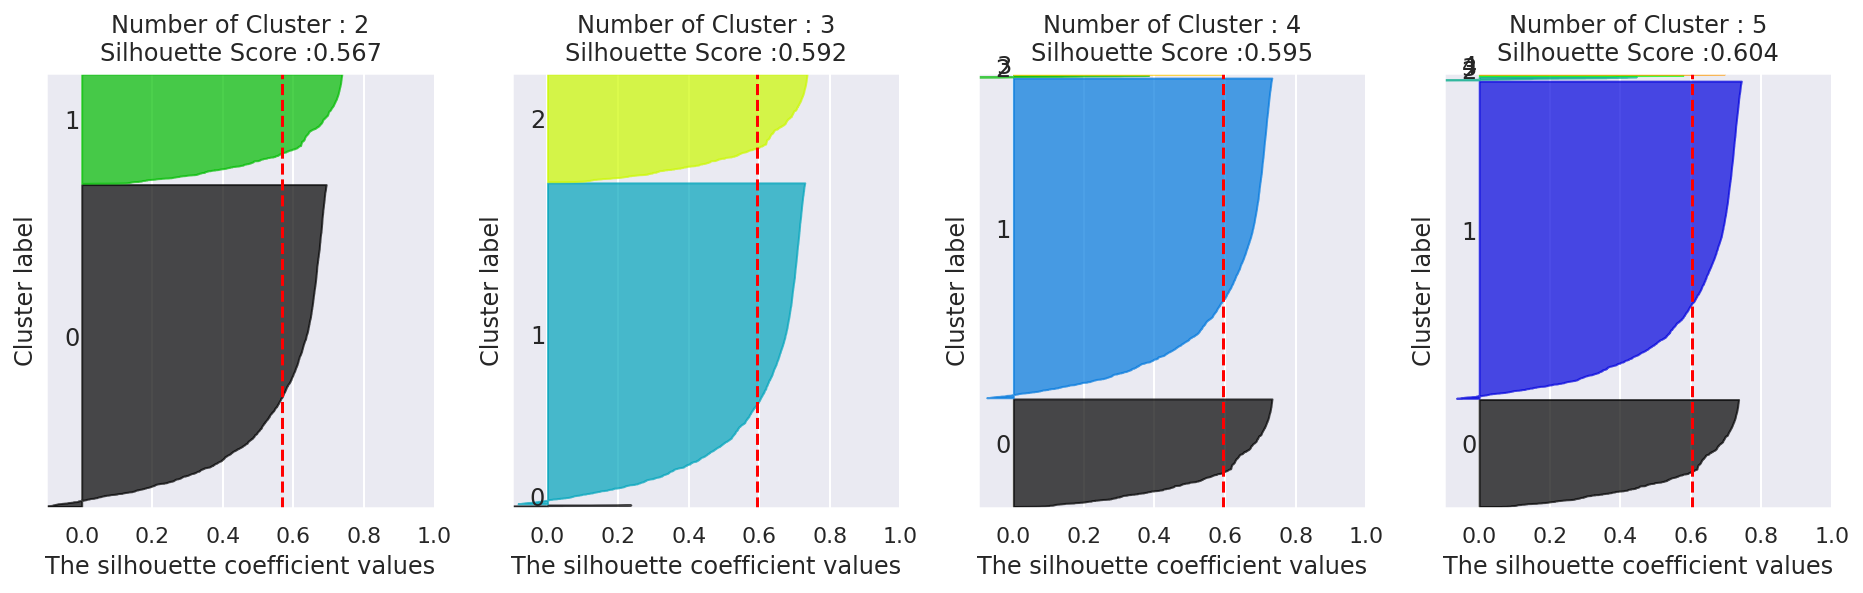

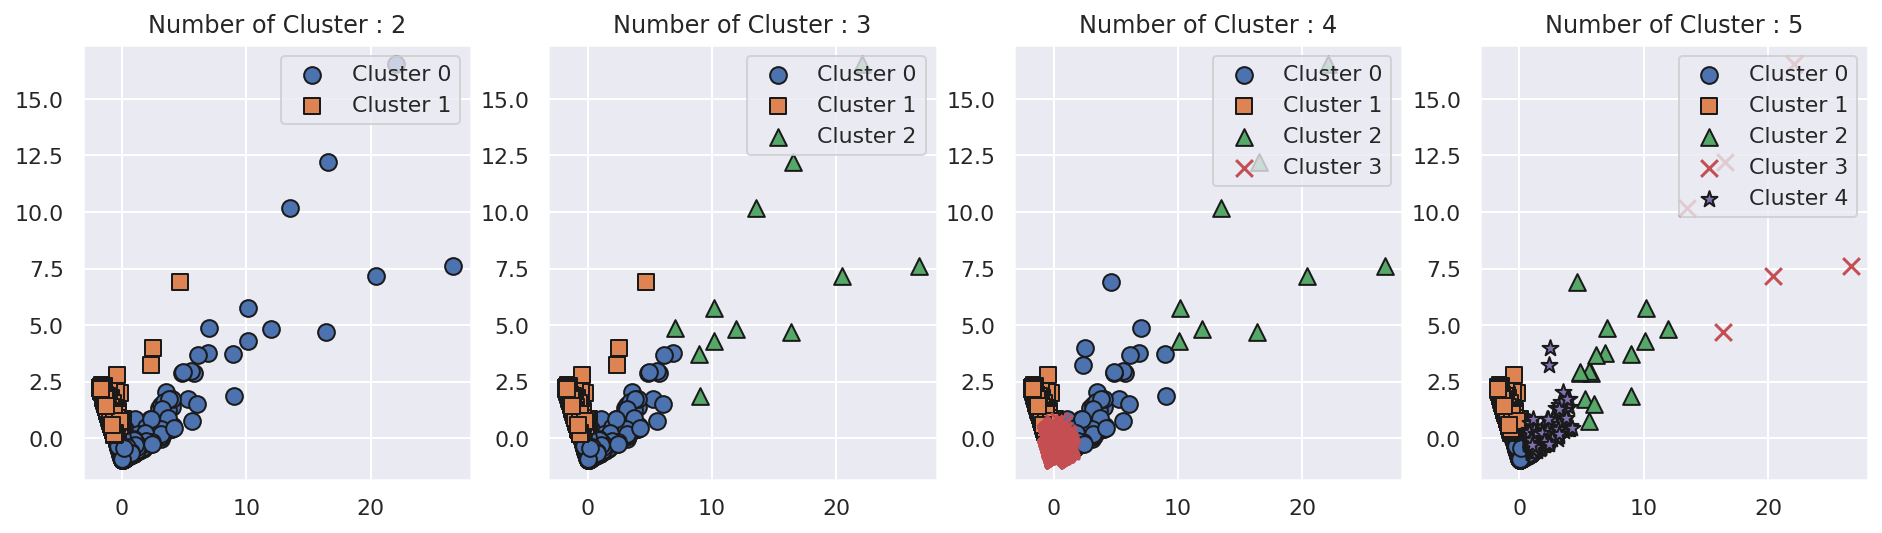

In [29]:
visualize_silhouette([2,3,4,5],X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5],X_features_scaled)

*   군집수가 2일 때는 0번 군집의 실루엣 계수가 대부분 평균 아래이다.
*   군집수가 3인 경우는 2번 군집, 4인 경우는 2,3번 군집의 데이터 건수가 매우 작다.
*   이는 앞서 왜곡된 분포를 확인했듯이 소매업체의 대규모 주문이 소수의 군집을 이룬것이다.
*   이렇게 특이한 데이터 셋을 분리하는 것이 군집화의 목표 중 하나이다.
*   다만 이 경우 왜곡정도가 너무 심해 굳이 군집분석하지 않아도 충분히 분리 가능하다.
*   실제 이런 자료를 다루는 도메인이 있다면 이런 결과를 미리 알았을 것이다.

In [30]:
# 로그 변환
cust_df['Recency_log'] = np.log1p(cust_df['Recency'])
cust_df['Frequency_log'] = np.log1p(cust_df['Frequency'])
cust_df['Monetary_log'] = np.log1p(cust_df['Monetary'])

# StandardScaler
X_features = cust_df[['Recency_log','Frequency_log','Monetary_log']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

# KMeans
kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df["cluster_label"] = labels

# 실루엣 스코어
silhouette_kmeans = silhouette_score(X_features_scaled, labels)
print(f"실루엣 스코어: {silhouette_kmeans:.3f}")

실루엣 스코어: 0.303


*   이번엔 왜곡 정도를 낮추기 위해 피처 로그 변환을 적용하였다.
*   나머지 과정은 동일하게 수행하였을 때 실루엣 스코어는 0.303으로 낮게 나타났다.

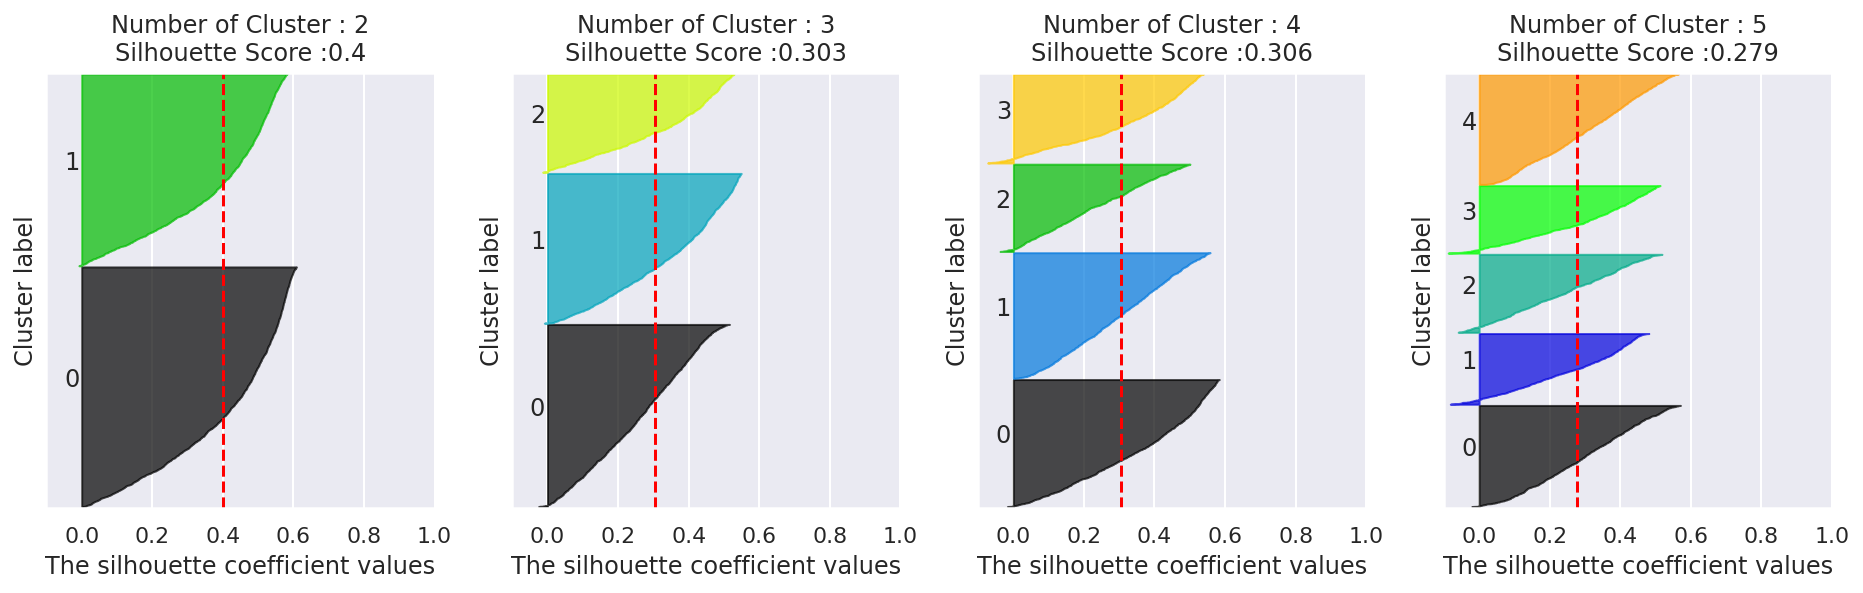

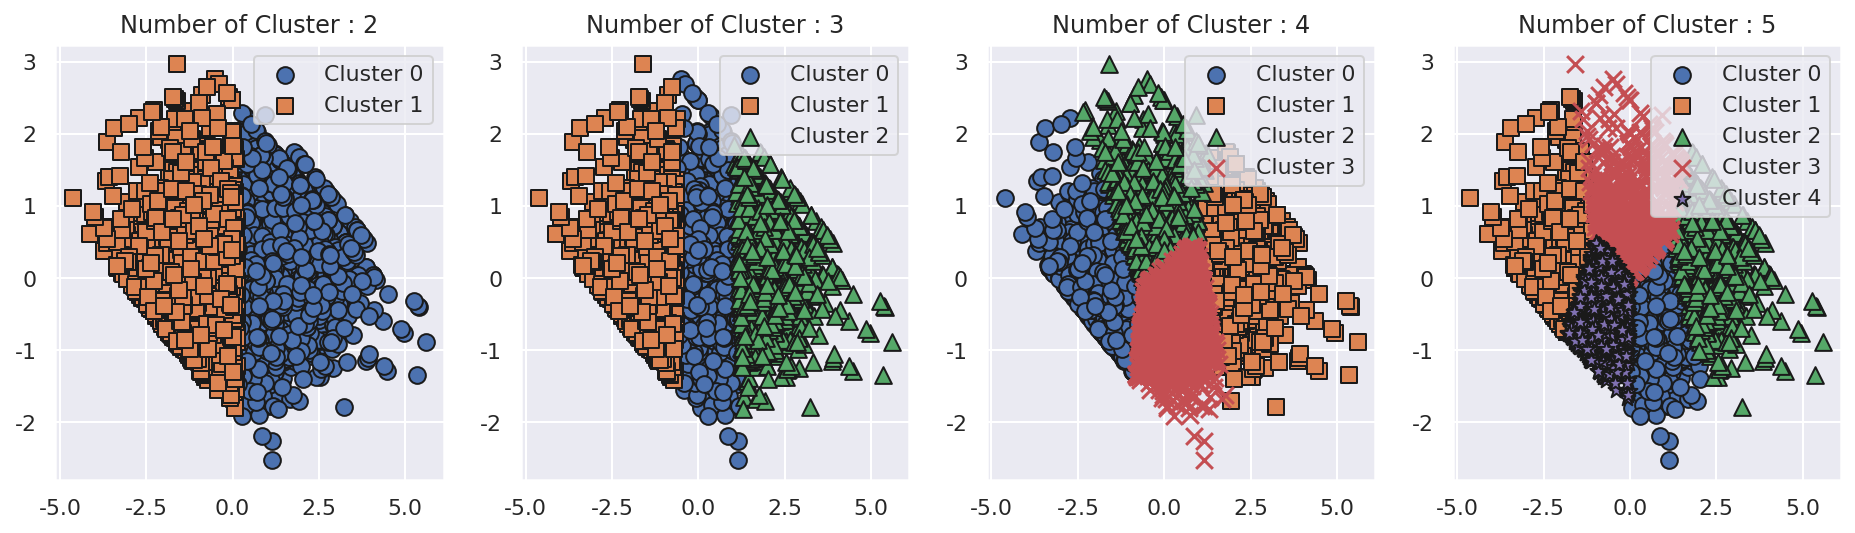

In [31]:
visualize_silhouette([2,3,4,5],X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5],X_features_scaled)

*   전체 실루엣 스코어가 감소한 대신 각 군집별 실루엣 스코어가 균일하게 나타났다.
*   이처럼 왜곡된 데이터 셋은 로그 변환으로 1차 변환 후 적용하면 더 나은 결과가 나오기도 한다.
*   참고로 위 시각화 코드를 자세히 보면 실루엣 스코어에서의 군집은 입력한 피처를 사용한다.
*   반면 군집 시각화 함수는 입력한 피처를 받아 PCA 적용 후 군집을 만든다.